In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from itertools import product
from numpy.linalg import norm

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from pandas import DataFrame

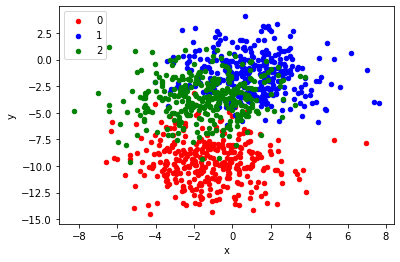

In [ ]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [ ]:
# one hot encode output variable
y1 = keras.utils.to_categorical(y)

In [ ]:
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y1[:n_train], y1[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (900, 2)


In [ ]:
# making the model
model = keras.Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0)

Train: 0.780, Test: 0.830


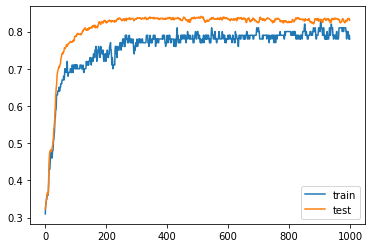

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# **Horizontal Voting Ensemble-**

In [ ]:
# create directory for models
os.makedirs('model')
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
	# fit model for a single epoch
	model.fit(trainX, trainy, epochs=1, verbose=0)
	# check if we should save the model
	if i >= n_save_after:
		model.save('models/model_' + str(i) + '.h5')

In [ ]:
# load models from file
def load_all_models(n_start, n_end):
	all_models = list()
	for epoch in range(n_start, n_end):
		# define filename for this ensemble
		filename = 'models/model_' + str(epoch) + '.h5'
		# load model from file
		model = keras.models.load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [ ]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [ ]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [ ]:
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))

>loaded models/model_950.h5
>loaded models/model_951.h5
>loaded models/model_952.h5
>loaded models/model_953.h5
>loaded models/model_954.h5
>loaded models/model_955.h5
>loaded models/model_956.h5
>loaded models/model_957.h5
>loaded models/model_958.h5
>loaded models/model_959.h5
>loaded models/model_960.h5
>loaded models/model_961.h5
>loaded models/model_962.h5
>loaded models/model_963.h5
>loaded models/model_964.h5
>loaded models/model_965.h5
>loaded models/model_966.h5
>loaded models/model_967.h5
>loaded models/model_968.h5
>loaded models/model_969.h5
>loaded models/model_970.h5
>loaded models/model_971.h5
>loaded models/model_972.h5
>loaded models/model_973.h5
>loaded models/model_974.h5
>loaded models/model_975.h5
>loaded models/model_976.h5
>loaded models/model_977.h5
>loaded models/model_978.h5
>loaded models/model_979.h5
>loaded models/model_980.h5
>loaded models/model_981.h5
>loaded models/model_982.h5
>loaded models/model_983.h5
>loaded models/model_984.h5
>loaded models/model

In [ ]:
trainy, testy = y[:n_train], y[n_train:]
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = keras.utils.to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

> 1: single=0.830, ensemble=0.830
> 2: single=0.830, ensemble=0.830
> 3: single=0.827, ensemble=0.830
> 4: single=0.827, ensemble=0.829
> 5: single=0.828, ensemble=0.827
> 6: single=0.827, ensemble=0.827
> 7: single=0.827, ensemble=0.827
> 8: single=0.828, ensemble=0.827
> 9: single=0.828, ensemble=0.827
> 10: single=0.827, ensemble=0.827
> 11: single=0.826, ensemble=0.827
> 12: single=0.827, ensemble=0.827
> 13: single=0.826, ensemble=0.828
> 14: single=0.829, ensemble=0.828
> 15: single=0.830, ensemble=0.828
> 16: single=0.826, ensemble=0.828
> 17: single=0.827, ensemble=0.827
> 18: single=0.827, ensemble=0.826
> 19: single=0.828, ensemble=0.826
> 20: single=0.828, ensemble=0.828
> 21: single=0.826, ensemble=0.827
> 22: single=0.826, ensemble=0.826
> 23: single=0.826, ensemble=0.827
> 24: single=0.827, ensemble=0.827
> 25: single=0.823, ensemble=0.826
> 26: single=0.826, ensemble=0.827
> 27: single=0.823, ensemble=0.827
> 28: single=0.824, ensemble=0.826
> 29: single=0.824, ensemble=

Accuracy 0.828 (0.002)


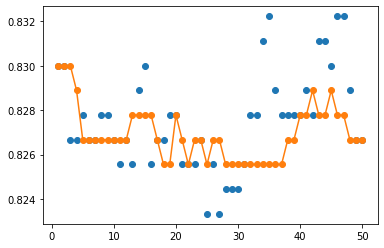

In [ ]:
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.show()

we can see that the ensemble accuracy is quite stable and has a lower varience than the single models.

#  **Average Ensemble**

In [ ]:
# fit model on dataset
def fit_model(trainX, trainy):
	trainy_enc = keras.utils.to_categorical(trainy)
	# define model
	model = keras.Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model

In [ ]:
n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = keras.utils.to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

> 1: single=0.831, ensemble=0.831
> 2: single=0.836, ensemble=0.837
> 3: single=0.834, ensemble=0.834
> 4: single=0.823, ensemble=0.836
> 5: single=0.832, ensemble=0.837
> 6: single=0.830, ensemble=0.831
> 7: single=0.837, ensemble=0.834
> 8: single=0.831, ensemble=0.832
> 9: single=0.838, ensemble=0.836
> 10: single=0.838, ensemble=0.836


Accuracy 0.833 (0.004)


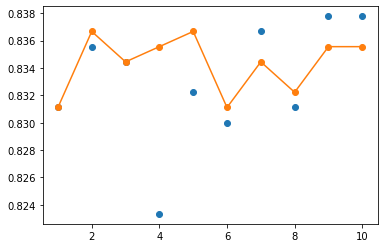

In [ ]:
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.show()









We can see using the average ensemble we get an accuracy that is neither too high nor too low there by reducing our models varience.

#  **Grid Search Weighted Average Ensemble**

In [ ]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	summed = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [ ]:
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [ ]:
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

In [ ]:
# grid search weights
def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)

In [ ]:
# fit all models
n_members = 3
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc =  keras.utils.to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Model 1: 0.833
Model 2: 0.838
Model 3: 0.832
Equal Weights Score: 0.837
>[0. 0. 1.] 0.832
>[0. 1. 0.] 0.838
>[0.   0.75 0.25] 0.840
>[0.         0.88888889 0.11111111] 0.841
Grid Search Weights: [0.0, 0.888888888888889, 0.11111111111111112], Score: 0.841
